In [105]:
%pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.6/533.6 kB 1.5 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [39]:
import seaborn as sns
import pandas
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt; plt.style.use('dark_background')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from time import time
import shap
from sklearn import tree

In [3]:
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", 
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
             "srv_diff_host_rate", "dst_host_count","dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
kdd_data_corrected = pandas.read_csv("corrected.csv", header=None, names = col_names)

#Converting all the new attack labels to 'attack.'
labels = kdd_data_corrected['label'].copy()
labels[labels != 'normal.'] = 'attack.'
labels.value_counts()

label
attack.    250436
normal.     60593
Name: count, dtype: int64

In [4]:
num_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
kdd_data_corrected = kdd_data_corrected[num_features].astype(float)
kdd_data_corrected.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Assuming 'kdd_data_corrected' is your DataFrame and 'num_features' is the list of numerical feature columns
scaler = MinMaxScaler()

# Apply Min-Max scaling to all numerical feature columns
scaled_features = scaler.fit_transform(kdd_data_corrected[num_features])

# Create a new DataFrame with the scaled values
scaled_features_df = pandas.DataFrame(scaled_features, columns=num_features)

# If you want to keep the scaled data in the original DataFrame
kdd_data_corrected[num_features] = scaled_features_df

In [6]:
X_train, X_test, y_train, y_test = train_test_split(kdd_data_corrected[num_features], labels, test_size=0.2, random_state=42)

Trained in 6.726 seconds
Accuracy is 0.9812.


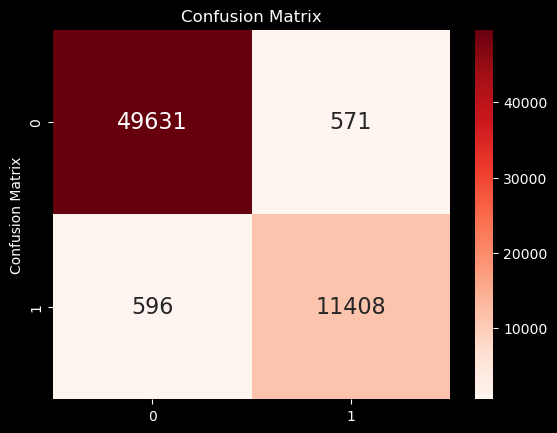

In [40]:
#Training a classifier with n_estimators = 50
clf = RandomForestClassifier(
    random_state = 0,
    n_estimators = 50
)

t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

# Confusion Matrix
fig_1, ax_1 = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred), annot=True, annot_kws={"size": 16}, fmt='g', cmap='Reds')
plt.ylabel('Confusion Matrix')
plt.title('Confusion Matrix')
plt.show()

Trained in 13.469 seconds
Accuracy is 0.9813.


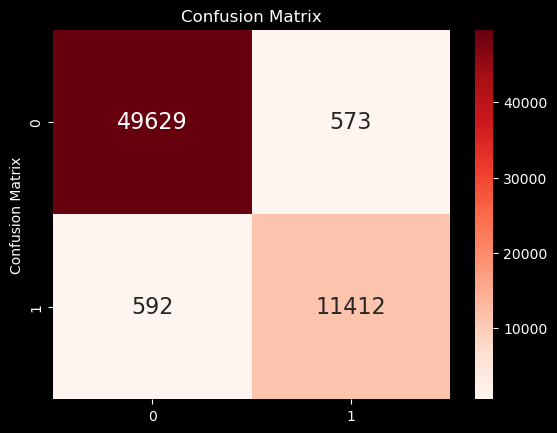

In [41]:
#Training a classifier with n_estimators = 100
clf = RandomForestClassifier(
    random_state = 0,
    n_estimators = 100
)

t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

# Confusion Matrix
fig_2, ax_2 = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred), annot=True, annot_kws={"size": 16}, fmt='g', cmap='Reds')
plt.ylabel('Confusion Matrix')
plt.title('Confusion Matrix')
plt.show()


Trained in 19.681 seconds
Accuracy is 0.9813.


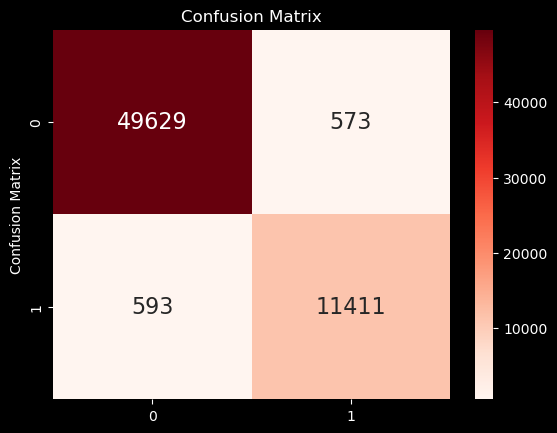

In [42]:
#Training a classifier with n_estimators = 150
clf = RandomForestClassifier(
    random_state = 0,
    n_estimators = 150
)

t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

# Confusion Matrix
fig_3, ax_3 = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred), annot=True, annot_kws={"size": 16}, fmt='g', cmap='Reds')
plt.ylabel('Confusion Matrix')
plt.title('Confusion Matrix')
plt.show()

In [13]:
explainer = shap.TreeExplainer(
    model=clf,
    data=None,
    model_output='raw',
    feature_perturbation='tree_path_dependent'
)

In [16]:
selected_X_test = X_test.head(100)

In [17]:
shap_value = explainer.shap_values(selected_X_test)

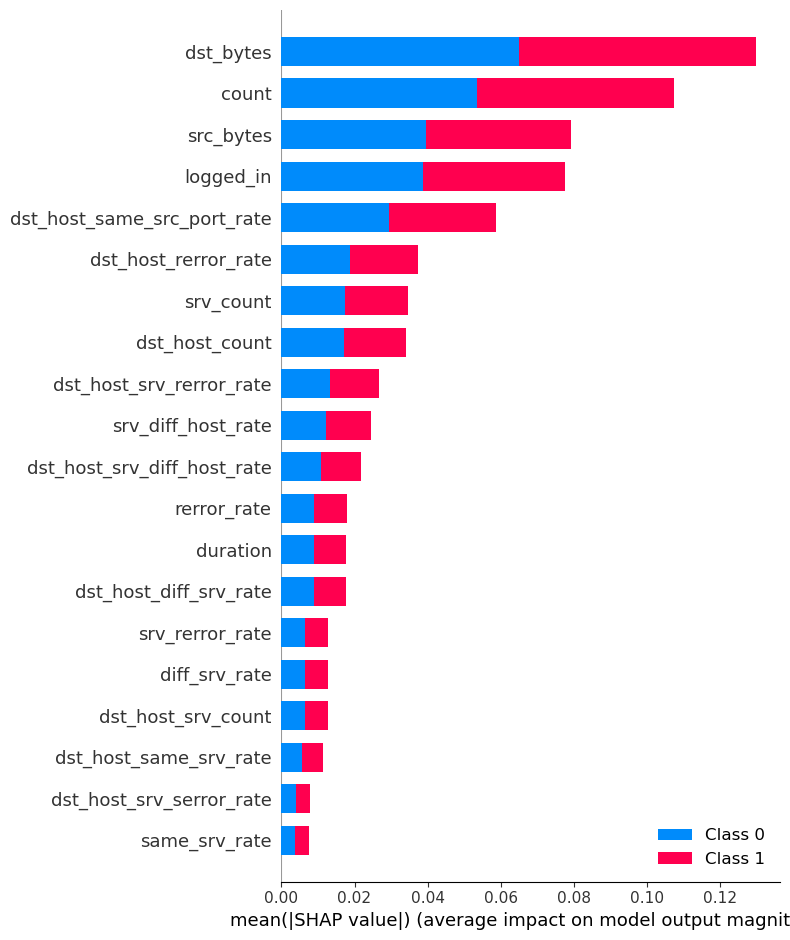

In [20]:
shap.summary_plot(shap_value, features=selected_X_test)

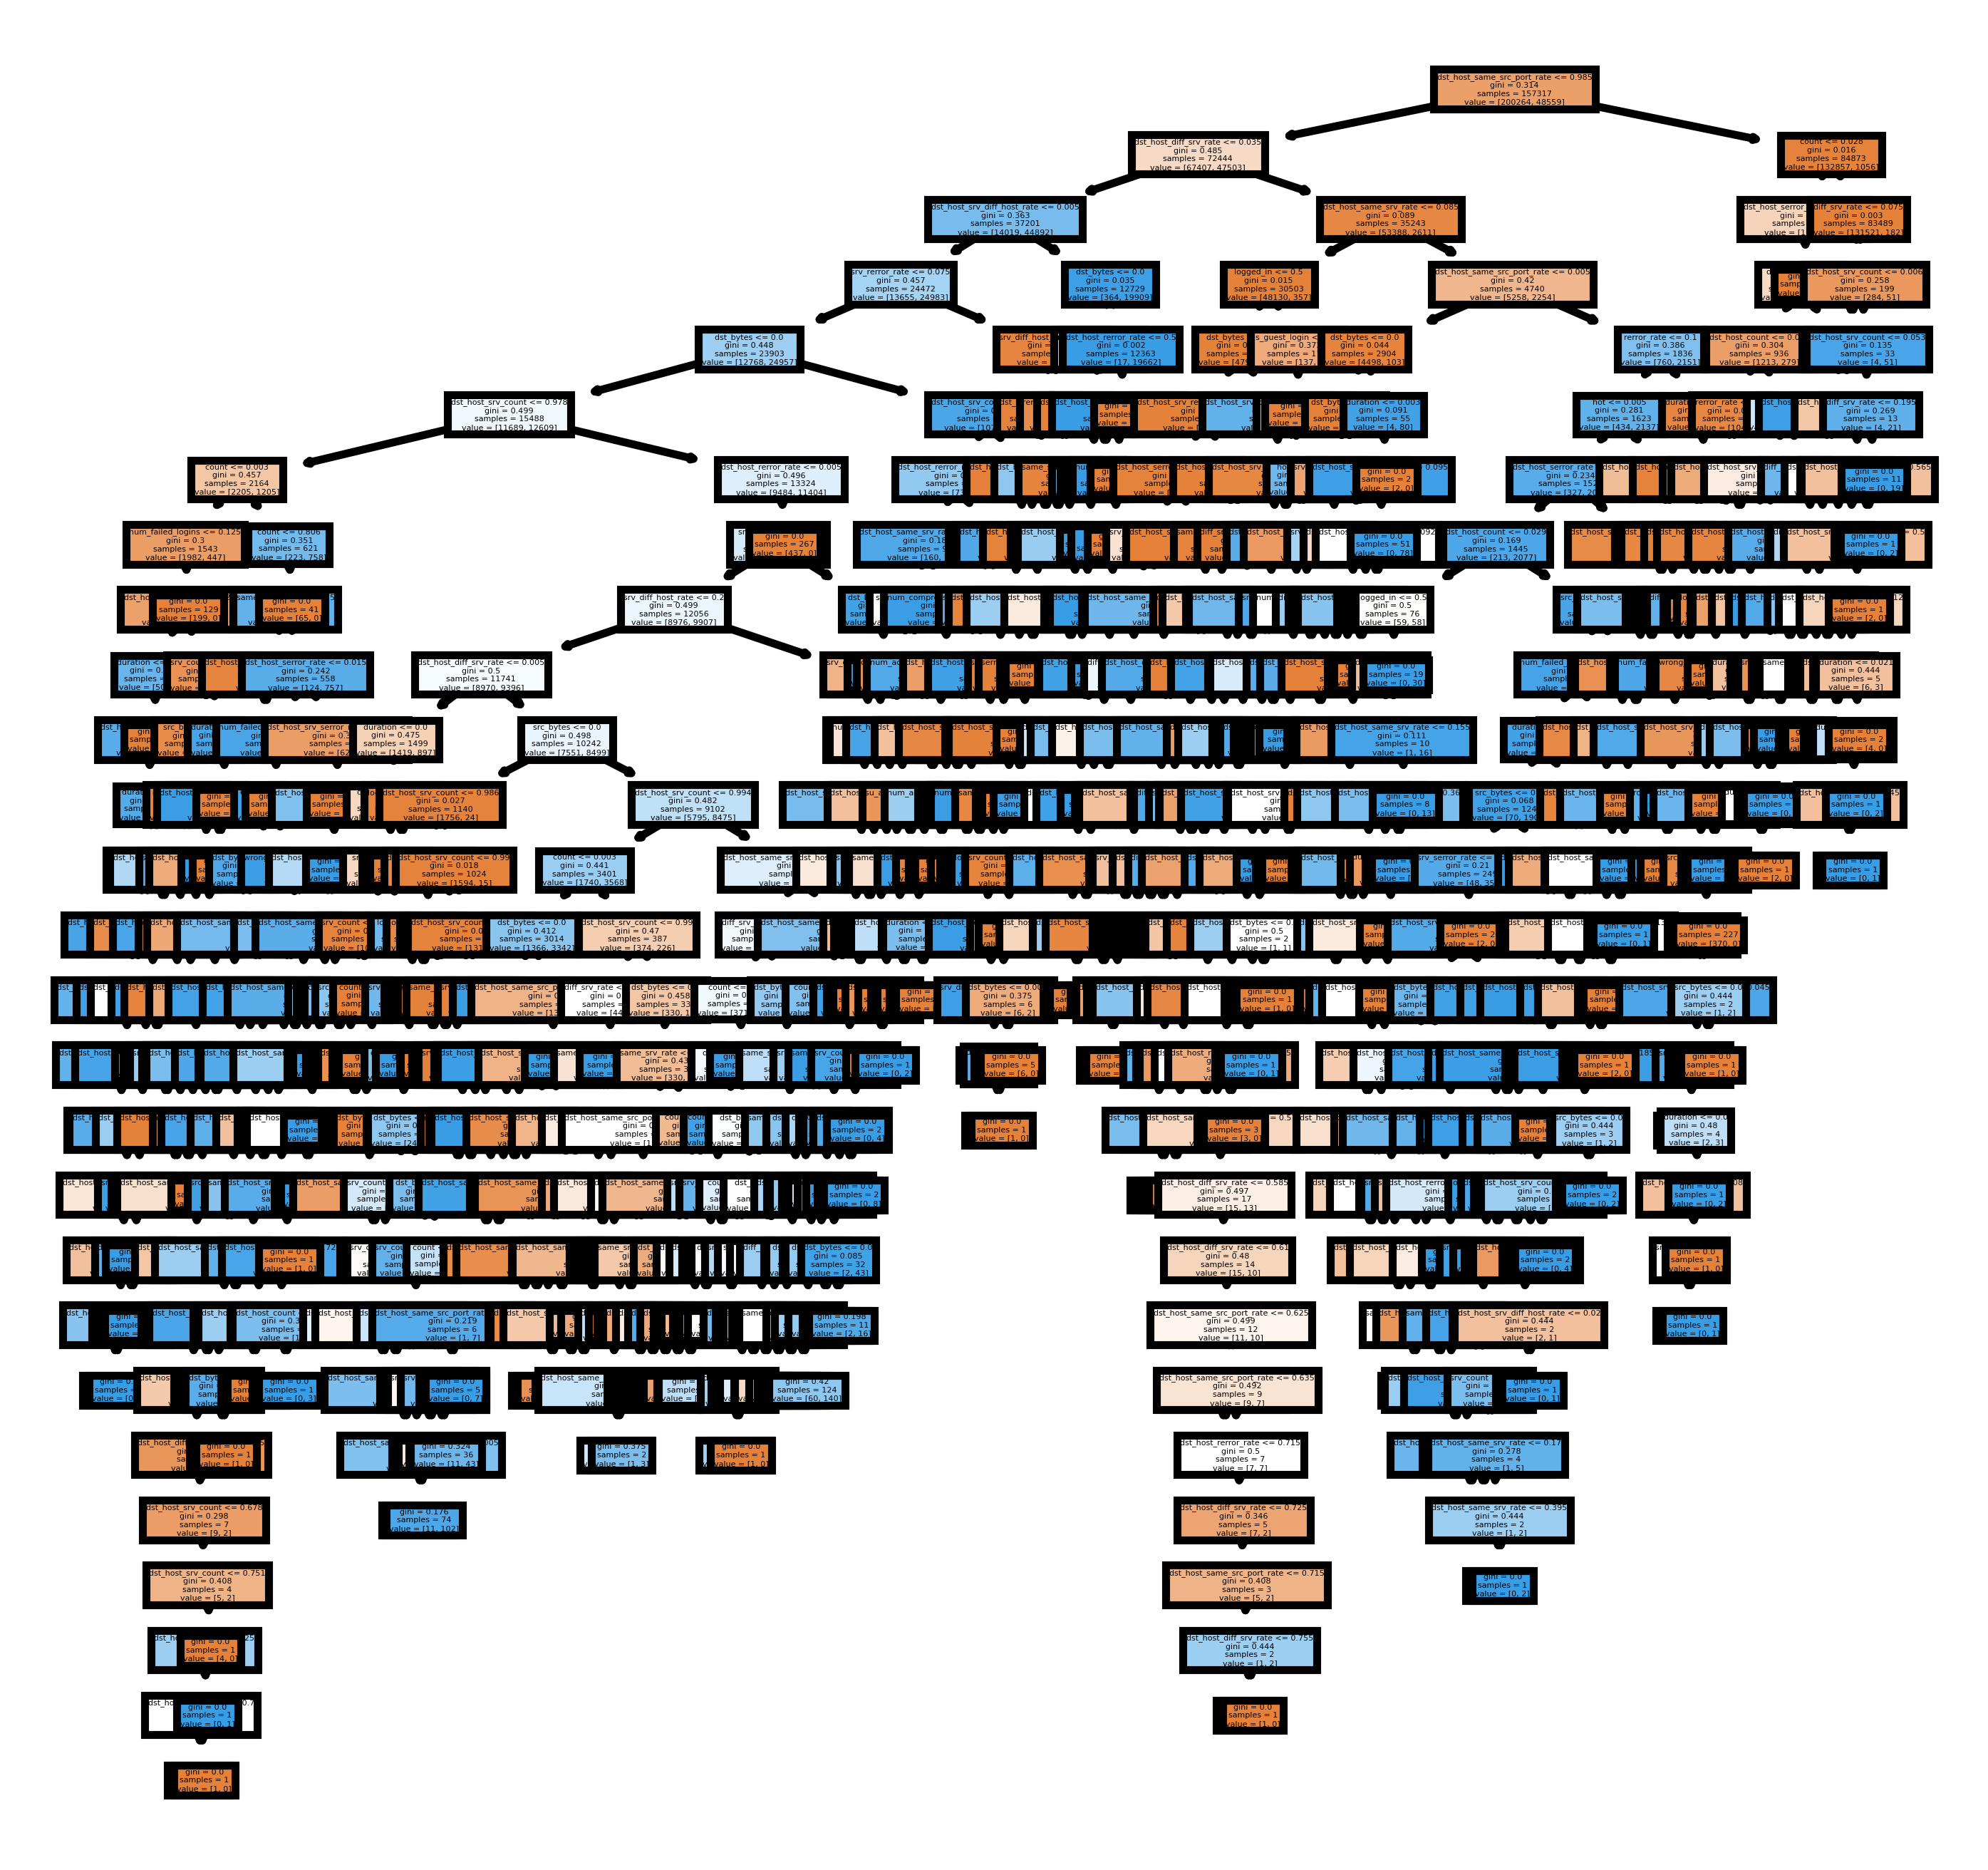

In [30]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[0],
                feature_names=num_features,
                filled=True)
fig.show()

In [31]:
fig.savefig('rf_individualtree.png')